# Introduction to SHAP for explaining regression models

### Objective

In this notebook, let us get familiar with the SHAP (SHapley  Additive exPlanation) framework for explaining regression models

### Installing the modules

In [1]:
# !pip install --upgrade pandas numpy matplotlib seaborn scikit-learn shap

### Loading the modules

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
np.random.seed(123)
import seaborn as sns
import matplotlib.pyplot as plt

import shap
print(f"Shap version used: {shap.__version__}")
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

Shap version used: 0.41.0


### About the data

**Red Wine Quality Dataset - Kaggle**
- Original Source - https://archive.ics.uci.edu/ml/datasets/wine+quality
- Kaggle Source - https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 


### Loading the data

In [3]:
# We will read the training data
data = pd.read_csv('dataset/winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data.shape

(1599, 12)

In [5]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
# Dropping missing values
data.fillna(0,inplace=True)
data.shape

(1599, 12)

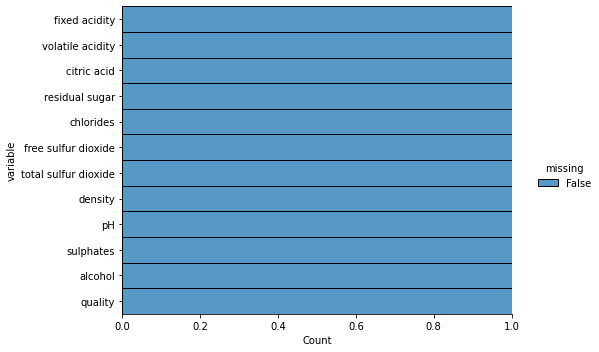

In [9]:
# Handling missing values
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5
)
plt.show()

No missing values found in the data. We can proceed with the model training process.

### Training the model

In [10]:
features = data.drop(columns=['quality'])
labels = data['quality']
# Dividing the data into training-test set with 80:20 split ratio
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2, random_state=123)

In [11]:
model = RandomForestRegressor(n_estimators=2000, max_depth=30, random_state=123)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=2000, random_state=123)

In [12]:
model.score(x_test, y_test)

0.49976030471036337

### Using SHAP for model interpretability

In [13]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

### Model interpretability using SHAP visualizations

#### Global interpretability with feature importance

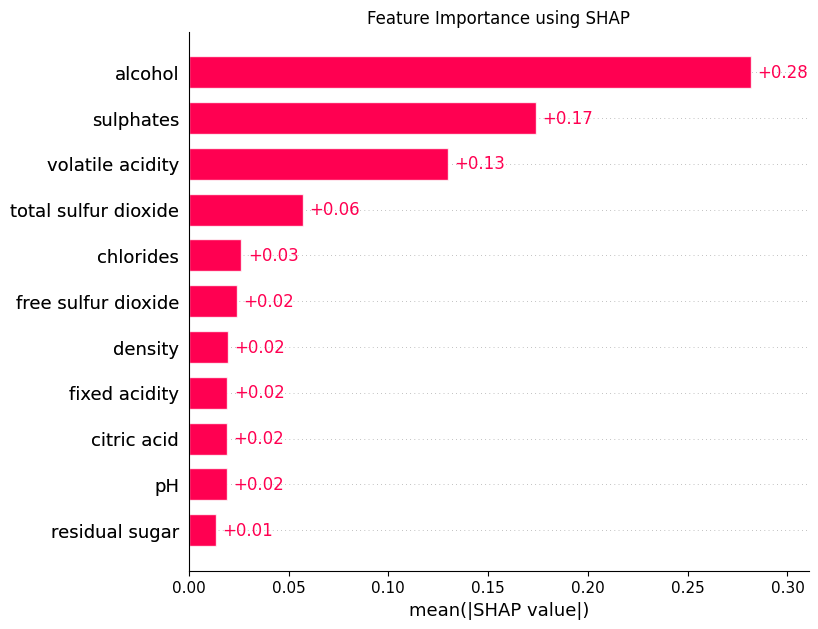

In [15]:
plt.title('Feature Importance using SHAP')
shap.plots.bar(shap_values, show=True, max_display=12)

- **Pro** - Easy to interpret and very helpful to identify the dominating features based on the collective interactive with other features using SHAP values.
- **Con** - Since it shows features based on mean absolute Shap values, it is hard to identify features which are positively influencing the model and negatively influencing the model.

#### Global interpretability with heatmap plots

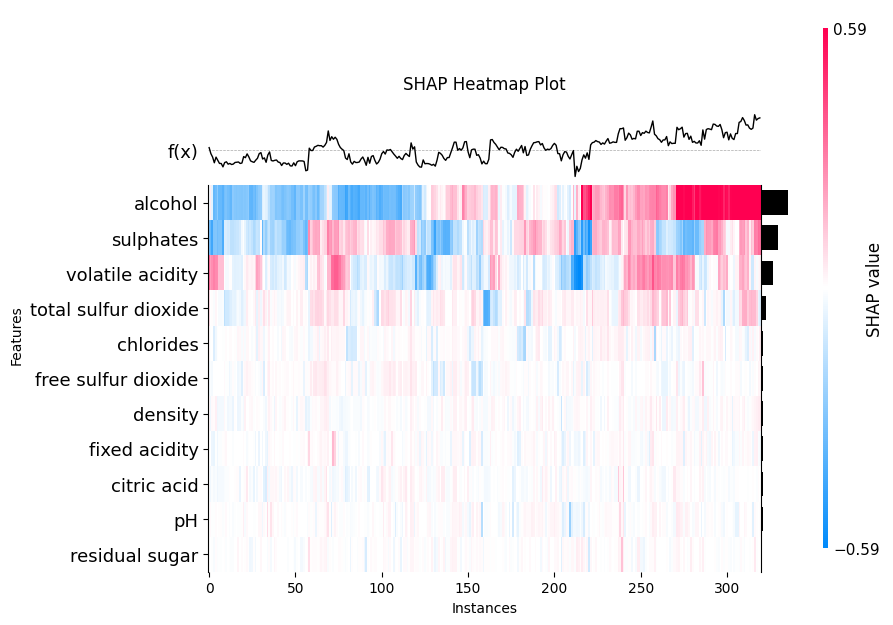

In [16]:
plt.title('SHAP Heatmap Plot')
shap.plots.heatmap(shap_values, max_display=12, show=False)
plt.gcf().axes[-1].set_box_aspect(100)
plt.ylabel('Features')
plt.show()

- **Pro** - Shows the most influential features and how the overall prediction varies with the data instances.
- **Con** - Can be complicated to interpret for any common user.

#### Global interpretability with SHAP summary plots

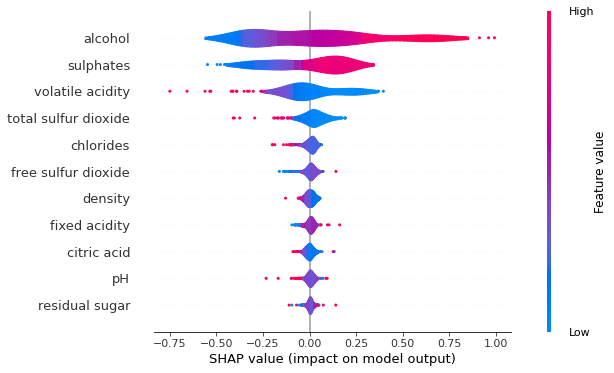

In [18]:
shap.summary_plot(shap_values, x_test, plot_type="violin", show=False)
plt.gcf().axes[-1].set_box_aspect(10)
plt.show()

SHAP Summary plots are interesting visualizations that does give alot of information and it is much better than feature importance bar plots. We can get the following information from SHAP summary plots.

## Reference

1. Red Wine Quality Dataset - Kaggle - https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
2. SHAP GitHub Project - https://github.com/slundberg/shap
3. SHAP Documentations - https://shap.readthedocs.io/en/latest/index.html